## Libraries

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

# Tensorflow libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#matplotlib style
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['legend.frameon'] = False


In [272]:
data_dir = "/home/titou/Documents/git/flower_image_class/data/flower_photos/"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'{image_count} images in the dataset')

3670 images in the dataset


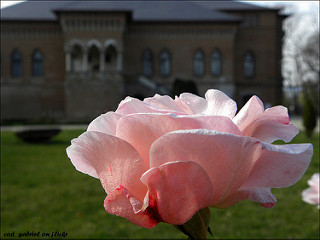

In [19]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[34]))

## Create the Dataset

In [36]:
# parameters
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split = 0.2,
    subset = "validation", 
    seed = 123, 
    image_size = (img_height, img_width),
    batch_size = batch_size
)

class_names = train_ds.class_names
print(class_names)



Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize dataset

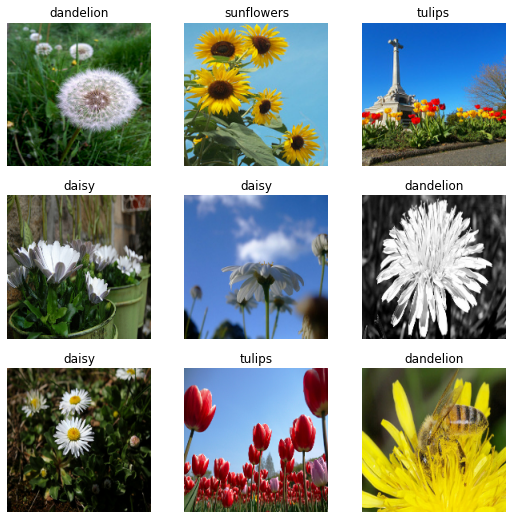

In [56]:
def plot_9_images(image_list, label_list):
    plt.figure(figsize=(9, 9))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_list[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")



for i, l in train_ds.take(1):
    images = i
    labels = l

plot_9_images(images, labels)

## Create model

In [58]:
#Preformance improvement for the IO part of the training

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [70]:
def create_model(num_classes):

    model = Sequential([
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])


    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model


## Train Model

In [71]:
def train(model, epochs, train_data, val_data):
    history = model.fit(train_data, validation_data = val_data, epochs = epochs)
    return history

In [72]:
# Create and train the model

num_classes = len(class_names)
model = create_model(num_classes)
epochs = 10
history = train(model, epochs=epochs, train_data=train_ds, val_data=validation_ds)

Epoch 1/10
92/92 [==============================] - 2s 17ms/step - loss: 1.4590 - accuracy: 0.3702 - val_loss: 1.2001 - val_accuracy: 0.5068
Epoch 2/10
92/92 [==============================] - 2s 17ms/step - loss: 1.0213 - accuracy: 0.5960 - val_loss: 0.9737 - val_accuracy: 0.6185
Epoch 3/10
92/92 [==============================] - 2s 17ms/step - loss: 0.8423 - accuracy: 0.6785 - val_loss: 0.8908 - val_accuracy: 0.6649
Epoch 4/10
92/92 [==============================] - 2s 17ms/step - loss: 0.6123 - accuracy: 0.7847 - val_loss: 0.8894 - val_accuracy: 0.6526
Epoch 5/10
92/92 [==============================] - 2s 17ms/step - loss: 0.3854 - accuracy: 0.8641 - val_loss: 1.0642 - val_accuracy: 0.6362
Epoch 6/10
92/92 [==============================] - 2s 17ms/step - loss: 0.2263 - accuracy: 0.9281 - val_loss: 1.2185 - val_accuracy: 0.6063
Epoch 7/10
92/92 [==============================] - 2s 17ms/step - loss: 0.1334 - accuracy: 0.9564 - val_loss: 1.4053 - val_accuracy: 0.6431
Epoch 8/10
92

## Results

In [96]:
def plot_acc_loss(history, epochs):

    epochs_range = range(epochs)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label = 'Training Accuracy')
    plt.plot(epochs_range, val_acc, label = 'Validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend()

    plt.show()

    

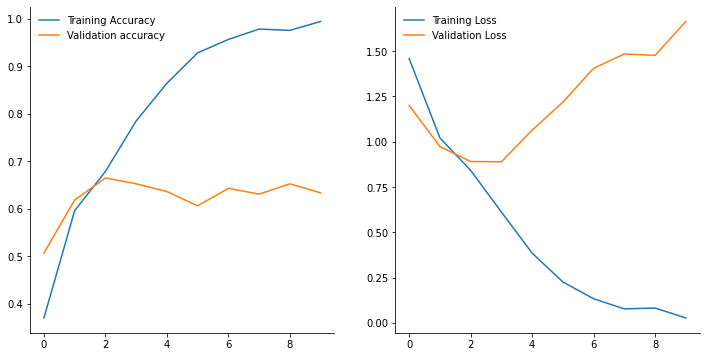

In [98]:


plot_acc_loss(history, 10)

## Data Augmentation

In [90]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
])


In [289]:
def plot_9_augment_image(image_list):
    plt.figure(figsize=(9,9))
    for i in range(9):
        aug_image = data_augmentation(image_list)
        plt.subplot(3, 3, i+1)
        plt.imshow(aug_image[0].numpy().astype('uint8'))
        plt.axis('off')
    

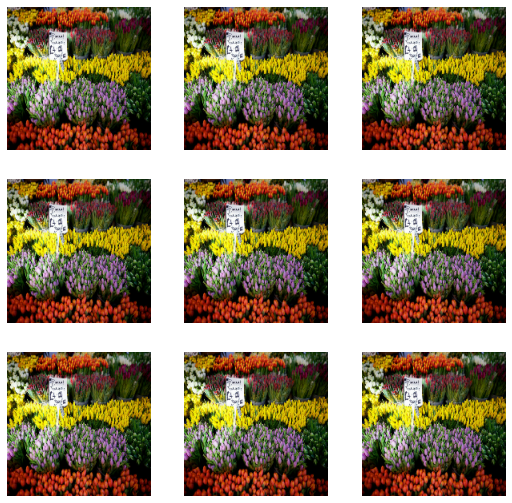

In [290]:
# visualize data augmented images

for i, _ in train_ds.take(1):
    image_list = i

plot_9_augment_image(image_list)


## Dropout and Data augmentation in training

In [357]:
def create_better_model(num_classes):

    model = Sequential([

        # Data augmentation
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),

        # Convolutional network
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])


    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model


In [358]:
better_model = create_better_model(num_classes)
epochs = 50
better_history = train(better_model, epochs, train_ds, validation_ds)


Epoch 1/50
92/92 [==============================] - 3s 28ms/step - loss: 1.3565 - accuracy: 0.3900 - val_loss: 1.1528 - val_accuracy: 0.5150
Epoch 2/50
92/92 [==============================] - 2s 27ms/step - loss: 1.0788 - accuracy: 0.5525 - val_loss: 0.9512 - val_accuracy: 0.6240
Epoch 3/50
92/92 [==============================] - 2s 27ms/step - loss: 0.9410 - accuracy: 0.6257 - val_loss: 0.8861 - val_accuracy: 0.6621
Epoch 4/50
92/92 [==============================] - 3s 28ms/step - loss: 0.8675 - accuracy: 0.6533 - val_loss: 0.7960 - val_accuracy: 0.6921
Epoch 5/50
92/92 [==============================] - 2s 27ms/step - loss: 0.7823 - accuracy: 0.6999 - val_loss: 0.8086 - val_accuracy: 0.6853
Epoch 6/50
92/92 [==============================] - 3s 28ms/step - loss: 0.7635 - accuracy: 0.7037 - val_loss: 0.7885 - val_accuracy: 0.6948
Epoch 7/50
92/92 [==============================] - 3s 28ms/step - loss: 0.7263 - accuracy: 0.7170 - val_loss: 0.7092 - val_accuracy: 0.7207
Epoch 8/50
92

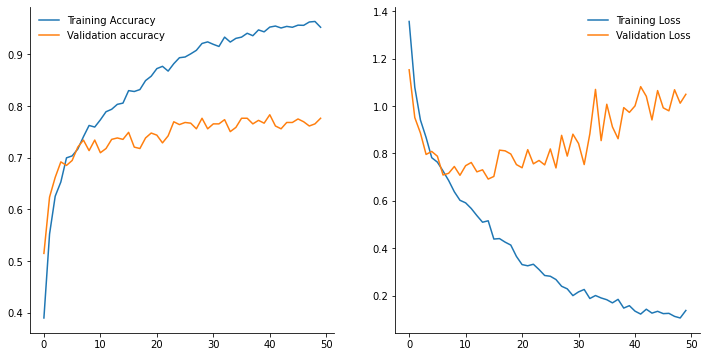

In [359]:
plot_acc_loss(better_history, epochs)